# recrutiment-data-analysis
Imagine that you run a candy factory, in which you manufacture various types of candy, chocolate bars and marshmallows.
You have very advanced machines that can manufacture multiple types of sweetness, but they may sometimes make mistakes (e.g. add chocolate to the marshmallows) and you’d like to detect this kind of mistakes before you ship the goods to stores.

Luckily, the machines measure some parameters of the produced sweetness, such as volume and weight of each produced item along with the machine id and timestamp.

Your goal is to identify outliers in that data (so that you can quickly detect that a machine is not functioning properly)

Directions:
 - Use pandas to load and clean the data (there may be some incorrect readings in the data set)
 - visualise the data (you may use matplotlib)
 - cluster the data and analyse distances of data points from the cluster centroids to detect outliers. You do not need to implement clustering on your own, find an implementation in sklearn.


Expected completion time: ca 1.5 hours

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('dataset.csv')

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [5]:
df.head()

,machine_id,timestamp,volume,weight
0,machine_2,1631751538,7.114575,13.093726401951036
1,machine_1,1631701818,45.841198,13.127754886435934
2,machine_2,1631751538,7.785276,11.992074845293077
3,machine_1,1631701818,45.491211,17.278758190021364
4,machine_2,1631701818,45.262785,15.934521964064135


In [7]:
df.machine_id.unique()

array(['machine_2', 'machine_1'], dtype=object)

In [8]:
df.timestamp.unique()

array([1631751538, 1631701818, 1631741862, 1631703173, 1631746425,
       1631704175, 1631702173, 1631744425, 1631721815])

In [9]:
df.shape

(140, 4)

In [12]:
df.dtypes

machine_id     object
timestamp       int64
volume        float64
weight         object
dtype: object

**Frist Thoughts:** We have 140 rows of datapoints. We know that we have two machines, and the data types for columns _weights_ and _timestamp_ need to be adjusted. Next we will look for data errors. And try to find out differences based on machine, and time.

In [13]:
df.timestamp = pd.to_datetime(df.timestamp, unit='s')

In [14]:
df.head()

,machine_id,timestamp,volume,weight
0,machine_2,2021-09-16 00:18:58,7.114575,13.093726401951036
1,machine_1,2021-09-15 10:30:18,45.841198,13.127754886435934
2,machine_2,2021-09-16 00:18:58,7.785276,11.992074845293077
3,machine_1,2021-09-15 10:30:18,45.491211,17.278758190021364
4,machine_2,2021-09-15 10:30:18,45.262785,15.934521964064135


In [15]:
df.timestamp.dt.day.unique()

array([16, 15])

In [17]:
df[df.timestamp.dt.day == 15 ].shape

(103, 4)

In [18]:
df[ df.timestamp.dt.day == 16 ].shape

(37, 4)

**NOTE**: We can use September 15 to perform our cluster analysis and see what this tells us about September 16.

In [19]:
df['weight'] = df['weight'].astype(float)

ValueError: could not convert string to float: 'measurement_error'

In [20]:
df['weight'] = df['weight'].replace('measurement_error', np.nan)
df['weight'] = df['weight'].astype(float)
df.dropna(inplace=True)

In [21]:
len(df)

138

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 139
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   machine_id  138 non-null    object        
 1   timestamp   138 non-null    datetime64[ns]
 2   volume      138 non-null    float64       
 3   weight      138 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 5.4+ KB


**We start preprocessing**

We are going to make a copy of our dataframe and scale the data before looking for clusters

In [23]:
from sklearn.preprocessing import MinMaxScaler

X = df.copy()
scaler = MinMaxScaler()
X['volume'] = scaler.fit_transform(X[['volume']])
X['weight'] = scaler.fit_transform(X[['weight']])

In [24]:
X

,machine_id,timestamp,volume,weight
0,machine_2,2021-09-16 00:18:58,0.196926,0.086043
1,machine_1,2021-09-15 10:30:18,0.642527,0.086324
2,machine_2,2021-09-16 00:18:58,0.204643,0.076929
3,machine_1,2021-09-15 10:30:18,0.638499,0.120665
4,machine_2,2021-09-15 10:30:18,0.635871,0.109545
...,...,...,...,...
135,machine_2,2021-09-15 10:30:18,0.612724,0.108221
136,machine_2,2021-09-15 10:30:18,0.651099,0.125411
137,machine_1,2021-09-15 10:30:18,0.644774,0.098508
138,machine_2,2021-09-15 21:37:42,0.992717,0.973737


**NOTE:** There was a row that contained a negative value for volume. I didn't notice the first time.

In [32]:
from sklearn.cluster import KMeans

X_train = X[X.timestamp.dt.day == 15].copy()
Y = X[X.timestamp.dt.day == 16 ].copy()

We will peform a KMeans cluster search with training set `X_train` and use the result to study `Y`

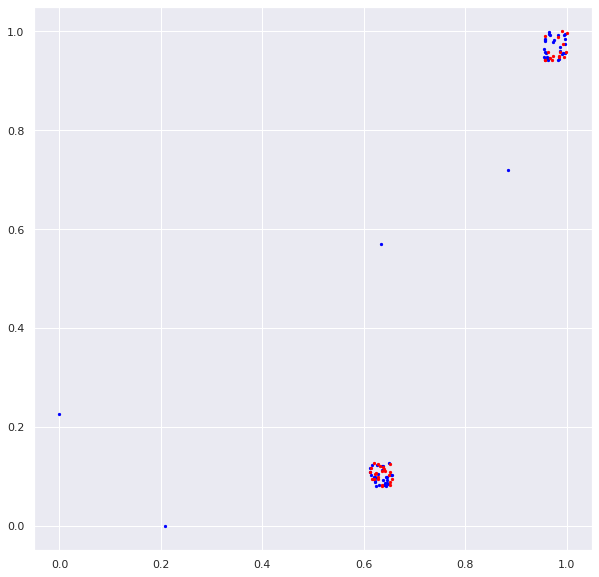

In [28]:
plt.rcParams['figure.figsize'] = (10,10)

X_1 = X_train[ X_train.machine_id == 'machine_1' ]
X_2 = X_train[ X_train.machine_id == 'machine_2' ]

plt.scatter(X_1.volume, X_1.weight, c='blue', s=5)
plt.scatter(X_2.volume, X_2.weight, c='red', s=5)

We can see from the plot that all outliers come from *machine_1* and there are two main clusters.
However we will apply the Elbow method to find the optimal number of clusters (and we know that the two big clusters are the _"good ones"_ )

Text(0.5, 1.0, 'Elbow Method To Find k')

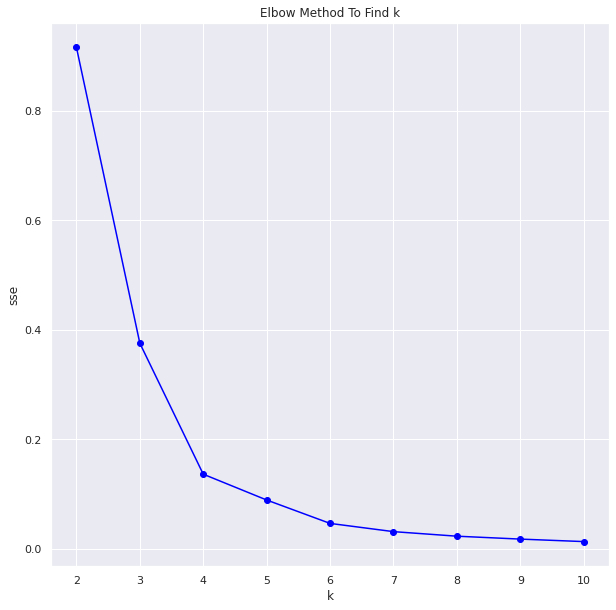

In [29]:
sse = []

for k in range(2,11):
    classifier = KMeans(n_clusters=k)
    classifier.fit(X_train[['volume','weight']])
    sse.append(classifier.inertia_)
    
plt.plot(range(2,11), sse, marker='o', c='blue')
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Elbow Method To Find k')

* We select k=4, as our number of clusters

* Another approach could be to use the values of machine_2 for the fitting/training step, but we chose the method that gives us more input data

In [38]:
classifier = KMeans(n_clusters=4)
classifier.fit(X_train[['volume','weight']])

labels = classifier.labels_
centers = classifier.cluster_centers_

Before analysing the values of Sep 16. We see what the previous model tells us about `X_train`

In [39]:
X_train['clusters'] = labels

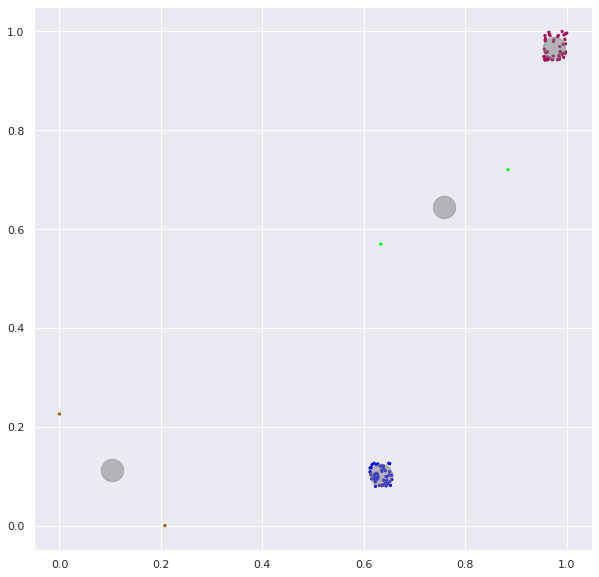

In [41]:
plt.scatter(X_train.volume, X_train.weight, c=X_train.clusters, s=5, cmap='brg')
plt.scatter(centers[:,0], centers[:,1], c='gray', s=500, alpha=0.5)

In [46]:
results = []
for cluster in range(4):
    aux = X_train[X_train.clusters == cluster]
    error = classifier.score(aux[['volume', 'weight']])
    n = len(aux)
    results.append([error, n, error/n])

results_df = pd.DataFrame(results, columns=['error', 'n', 'weighter-err'])

In [47]:
results_df

,error,n,weighter-err
0,-0.019014,52,-0.000366
1,-0.027555,45,-0.000612
2,-0.047130,2,-0.023565
3,-0.042760,2,-0.021380


* We see that clusters 2 and 3 are outliers.
* We study now `Y` and find elements in clusters 2 and 3

In [49]:
y_lables = classifier.predict(Y[['volume', 'weight']])
Y['clusters'] = y_lables
classifier.score(Y[['volume', 'weight']])

-0.4126858992464927

In [50]:
Y.head(10)

,machine_id,timestamp,volume,weight,clusters
0,machine_2,2021-09-16 00:18:58,0.196926,0.086043,2
2,machine_2,2021-09-16 00:18:58,0.204643,0.076929,2
5,machine_1,2021-09-16 00:18:58,0.200801,0.075857,2
9,machine_2,2021-09-16 00:18:58,0.195342,0.105045,2
11,machine_2,2021-09-16 00:18:58,0.187809,0.064483,2
13,machine_2,2021-09-16 00:18:58,0.227803,0.088015,2
15,machine_1,2021-09-16 00:18:58,0.186773,0.090861,2
16,machine_2,2021-09-16 00:18:58,0.186750,0.096637,2
20,machine_1,2021-09-16 00:18:58,0.190160,0.086924,2
24,machine_2,2021-09-16 00:18:58,0.189816,0.075228,2


In [51]:
Y.clusters.unique()

array([2], dtype=int32)

Text(0.5, 1.0, 'Final Conclusion')

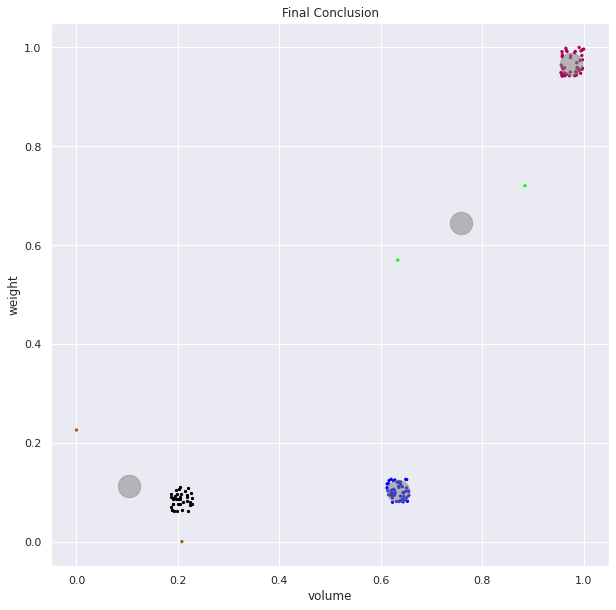

In [54]:
plt.scatter(X_train.volume, X_train.weight, c=X_train.clusters, s=5, cmap='brg')
plt.scatter(centers[:,0], centers[:,1], c='gray', s=500, alpha=0.5)
plt.scatter(Y.volume, Y.weight, c ='black', s=5)
plt.xlabel('volume')
plt.ylabel('weight')
plt.title('Final Conclusion')

Before we reach a conclusion we want to see the performance of the different machines on Sep 16, since all previous mistakes were done by machine_1

Text(0.5, 1.0, 'Machine Analysis')

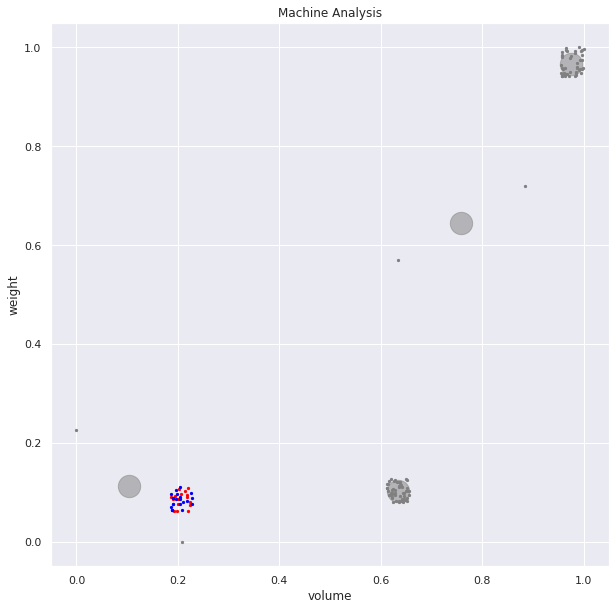

In [55]:
plt.scatter(X_train.volume, X_train.weight, c='gray', s=5)
plt.scatter(centers[:,0], centers[:,1], c='gray', s=500, alpha=0.5)

Y_1 = Y[Y.machine_id == 'machine_1']
plt.scatter(Y_1.volume, Y_1.weight, c ='red', s=5)
Y_2 = Y[Y.machine_id == 'machine_2']
plt.scatter(Y_2.volume, Y_2.weight, c ='blue', s=5)
plt.xlabel('volume')
plt.ylabel('weight')
plt.title('Machine Analysis')

### Conclusion

Based on the Cluster Analysis we can identify two main operations on the clusters 0 and 1
(elements at cluster 0 are smaller and much lighter, maybe they are marshmallows, and elements at cluster 1 are both heavier and bigger).

The outliers are in clusters 2 and 3. Maybe this is due to marshmallows treated as chocolate bars (cluster 2),
and chocolate bars treated as marshmallows (cluster 3).

In September 16, all elements are in cluster 2, indicating that someone made a mistake.
We can speculate that September 16 was going to be dedicated to producing only chocolate bars and someone thought they were going to produce only marshmallows.
In any case all output from September 16 is compromised in some manner.

We also noticed that all mistakes in September 15 were due to *machine_1*, either because is malfunctioning or because the people operating
this machine have less experience.
However this have nothing to do with the issue on September 16 since both machines are in cluster 2, and the outliers are not significant
(~5.8% of the output of Sepmber 15).

The model we produced allow us to improve quality in two ways:
* Track all elements and if they are not in cluster 0 or 1 they can be classified as low quality.
* Track batches, and if the weighted score is >0.001 classify the batch as low quality.